## Import libraries

In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import sklearn
import re 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import scipy

mpl.rcParams['figure.dpi'] = 300

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Import train, test, gender submission dataframes and visualise data

In [2]:
# Load the data
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
gender_submission = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

# Make dataframes
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)
combined_df = pd.concat([train_df,test_df], ignore_index=True)

# Set how many rows are shown in the dataframe
pd.set_option('display.min_rows', 10) 
pd.set_option('display.max_rows', 10) 

# Show the dataframe
display(combined_df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [3]:
combined_df.info()
type(train_df['Ticket'][0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


str

## Visualise differences between male and female survival rates at different ages

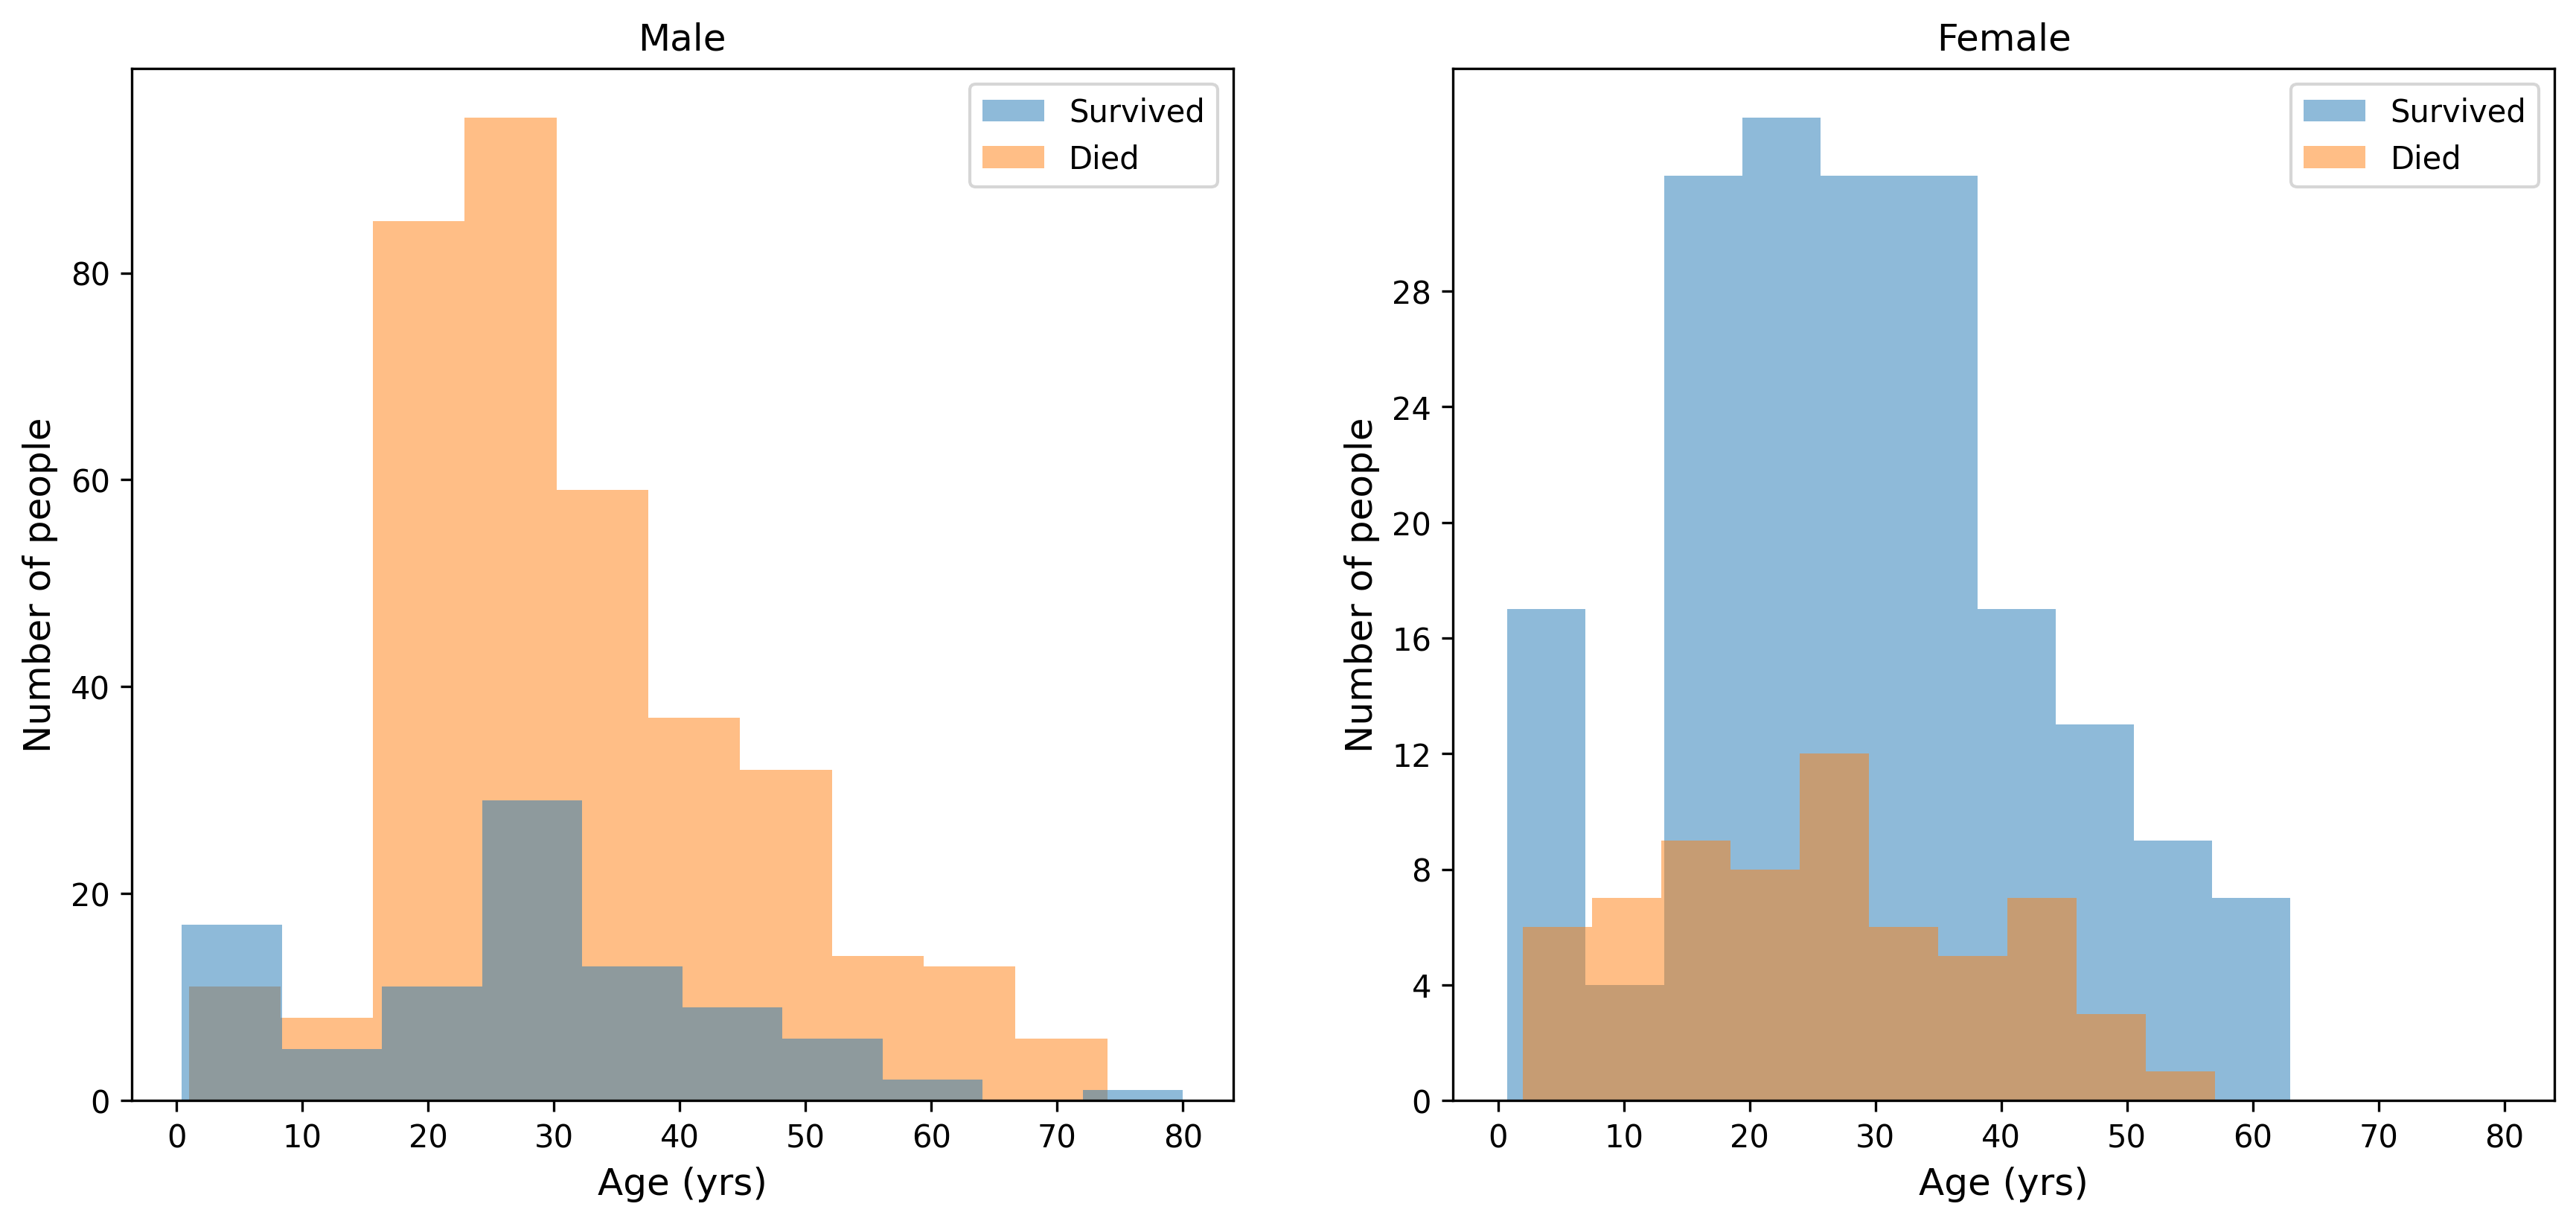

In [37]:
# Dataframes of male and female survivals
male_train_df = train_df.loc[train_df['Sex'] == 'male']
female_train_df = train_df.loc[train_df['Sex'] == 'female']

male_survived_df = male_train_df.loc[male_train_df['Survived'] == 1]
male_died_df = male_train_df.loc[male_train_df['Survived'] == 0]

female_survived_df = female_train_df.loc[female_train_df['Survived'] == 1]
female_died_df = female_train_df.loc[female_train_df['Survived'] == 0]

# Initiating the plots
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14,6), sharex=True)

# Male and female survived histograms, respectively
histogram_male_survived = ax0.hist(male_survived_df['Age'], bins=10, alpha=0.5,  label='Survived', color='C0', zorder=1);
histogram_male_died = ax0.hist(male_died_df['Age'], bins=10, alpha=0.5,  label='Died', color='C1', zorder=0);

histogram_female_survived = ax1.hist(female_survived_df['Age'], bins=10, alpha=0.5,  label='Survived');
histogram_female_died = ax1.hist(female_died_df['Age'], bins=10, alpha=0.5,  label='Died');

# Add a legend to ax0
ax0.legend()
ax1.legend()
# Set titles
ax0.set(title='Male', xlabel='Age', ylabel='Number of people');
ax1.set(title='Female', xlabel='Age', ylabel='Number of people');
# Set labels
ax0.set_xlabel('Age (yrs)', fontsize = 12)
ax0.set_ylabel('Number of people', fontsize = 12)
ax1.set_xlabel('Age (yrs)', fontsize = 12)
ax1.set_ylabel('Number of people', fontsize = 12)
# Set y ticks
y_axis_numbers = np.arange(0,32,4)
y_axis_numbers
ax1.set_yticks(y_axis_numbers);

## Visualise survival rates at different fare prices 

Text(0, 0.5, 'Number of people')

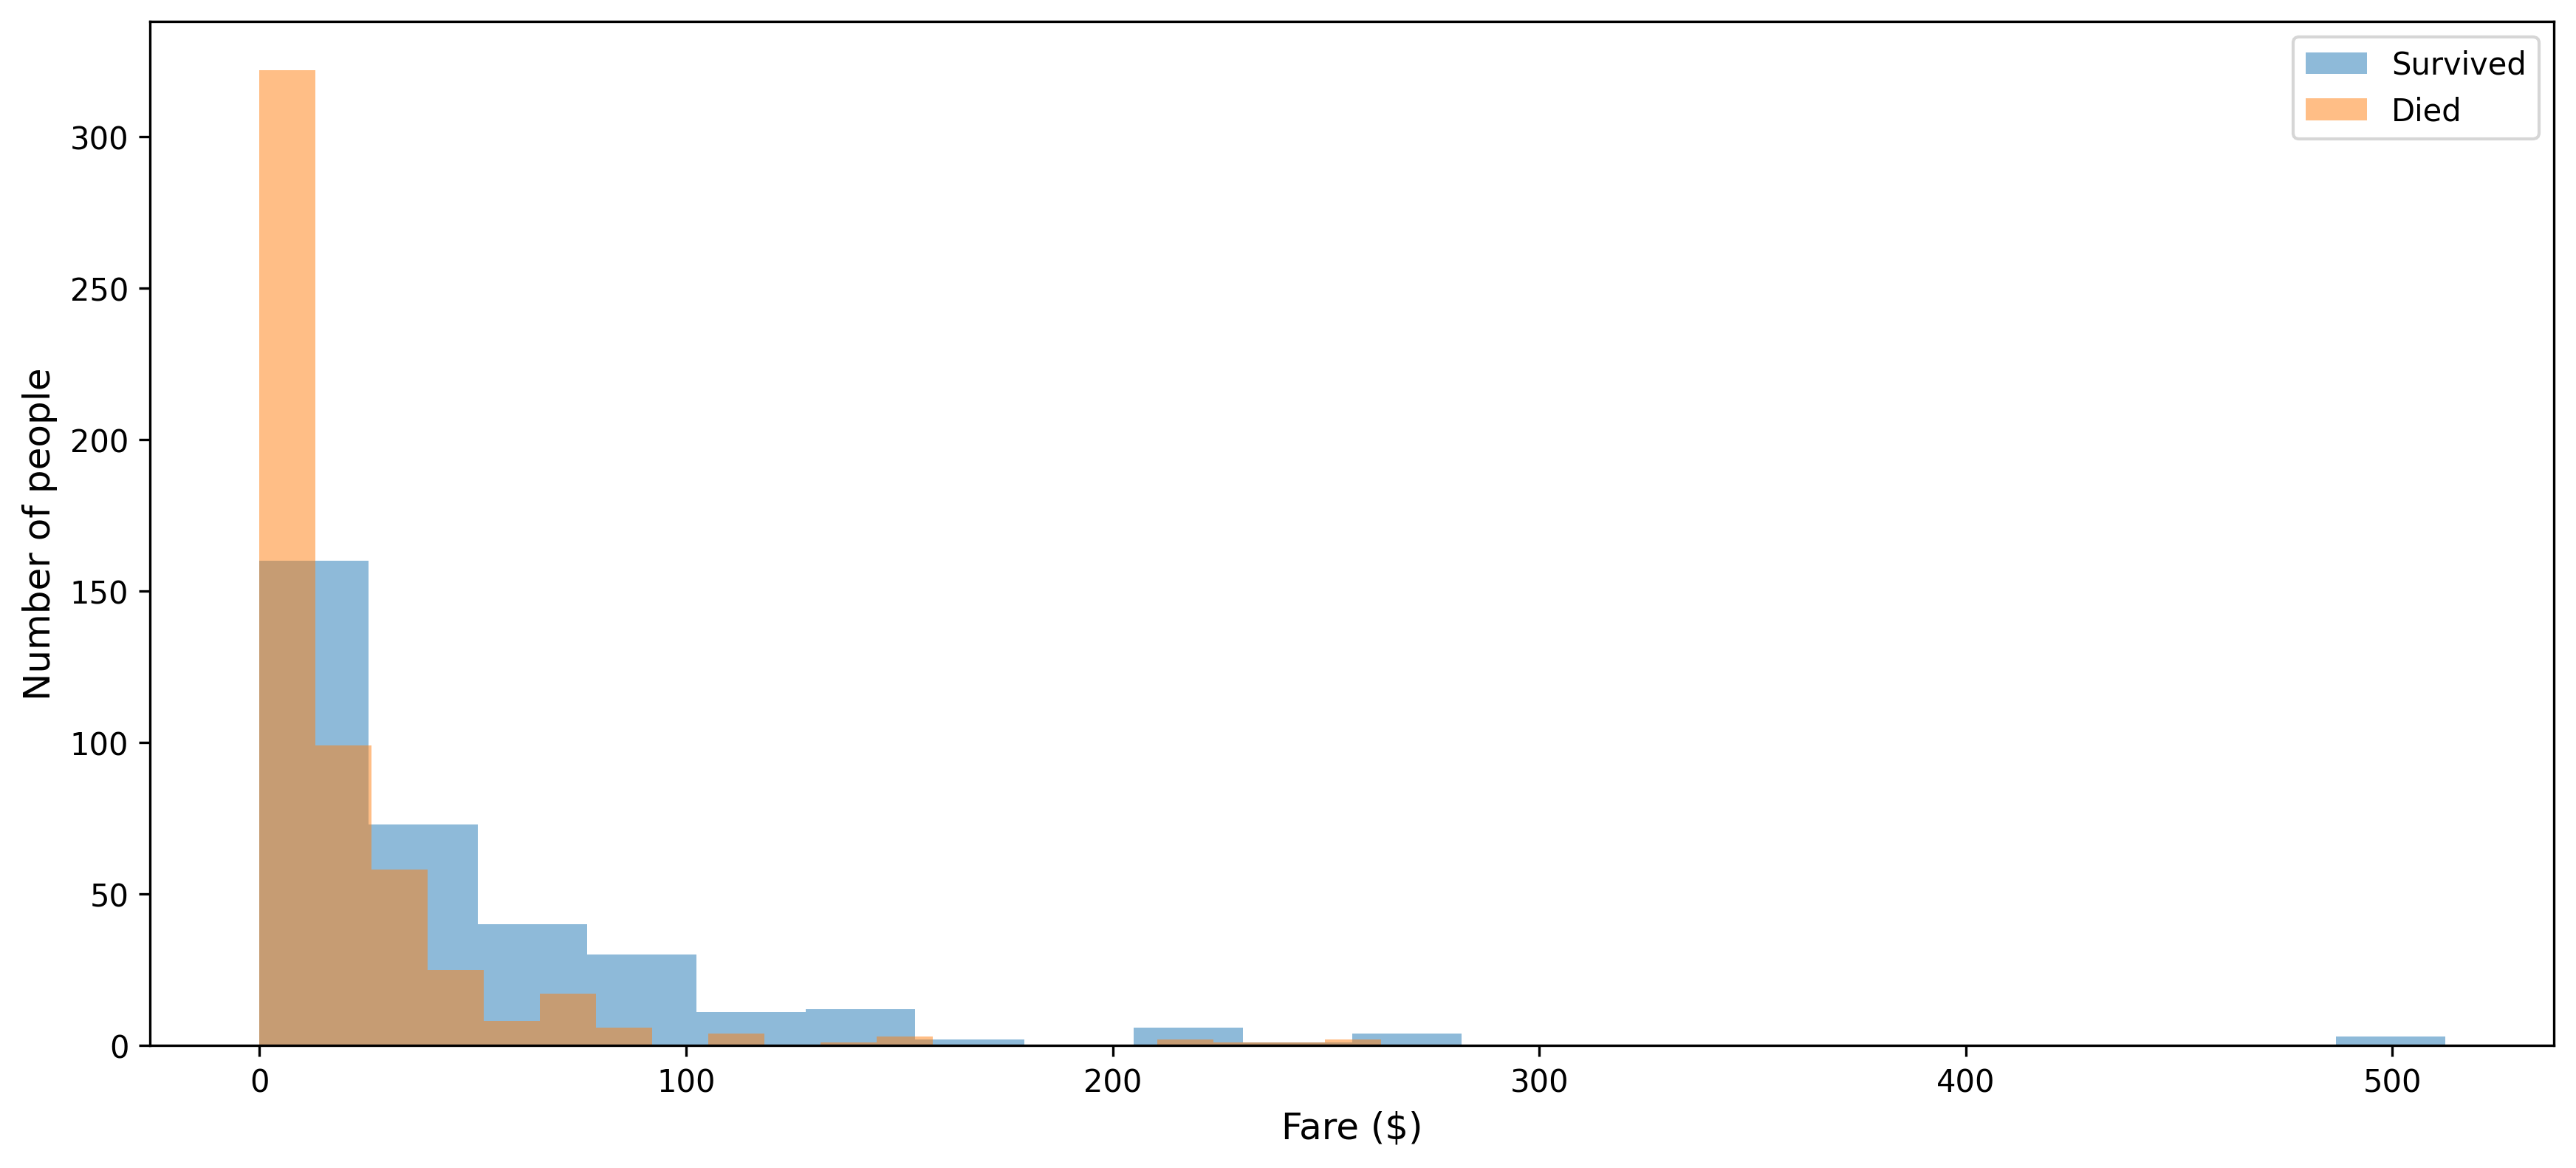

In [5]:
# Plot histograms of the number who survived/died according to fare price
survived_df = train_df.loc[train_df['Survived'] == 1]
died_df = train_df.loc[train_df['Survived'] == 0]

# Initiating the figures
fig, ax = plt.subplots(figsize=(14,6))

# Histograms of the survived and died based on fare price
survived_hist = ax.hist(survived_df['Fare'], bins=20, alpha=0.5,  label='Survived', color='C0', zorder=0);
died_ = ax.hist(died_df['Fare'], bins=20, alpha=0.5,  label='Died', color='C1', zorder=1);

# Add a legend to ax0
ax.legend()
# Set labels
ax.set_xlabel('Fare ($)', fontsize = 12)
ax.set_ylabel('Number of people', fontsize = 12)

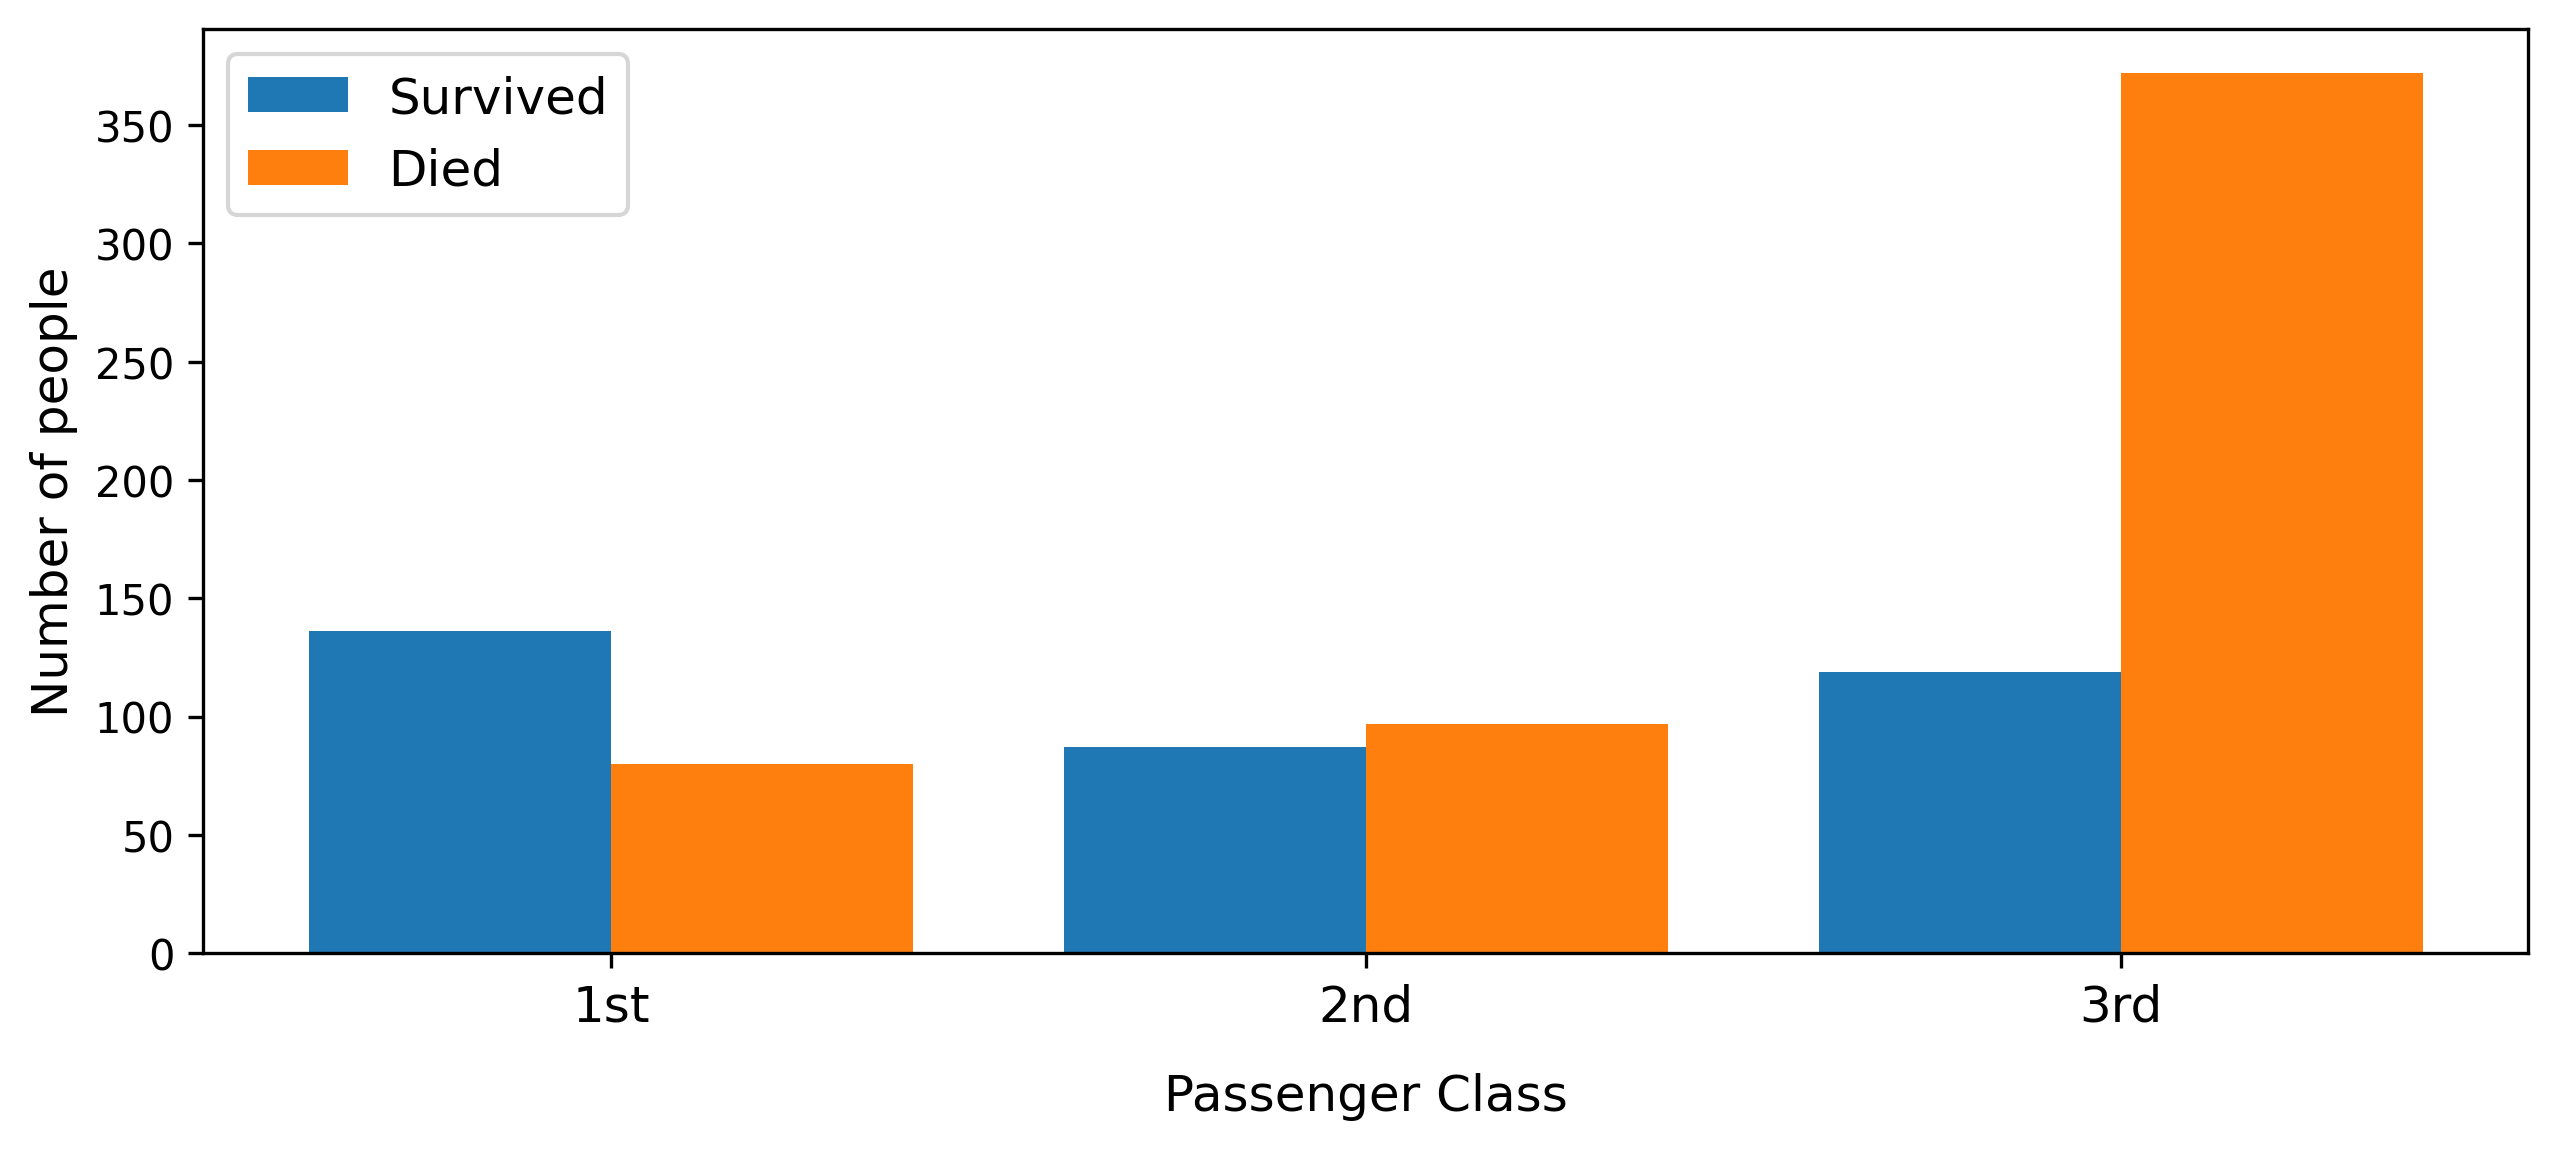

In [6]:
pclass1_survive = train_df.loc[(train_df['Survived'] == 1) & (train_df['Pclass'] ==1 )]
pclass1_die = train_df.loc[(train_df['Survived'] == 0) & (train_df['Pclass'] ==1 )]

pclass2_survive = train_df.loc[(train_df['Survived'] == 1) & (train_df['Pclass'] ==2 )]
pclass2_die = train_df.loc[(train_df['Survived'] == 0) & (train_df['Pclass'] ==2 )]

pclass3_survive = train_df.loc[(train_df['Survived'] == 1) & (train_df['Pclass'] ==3 )]
pclass3_die = train_df.loc[(train_df['Survived'] == 0) & (train_df['Pclass'] ==3 )]

survived = [len(pclass1_survive), len(pclass2_survive), len(pclass3_survive)]
died = [len(pclass1_die), len(pclass2_die), len(pclass3_die)]

fig, ax = plt.subplots(figsize=(10,4))

x = np.arange(3)
width = 0.4

ax.bar(x-0.2, survived, width) 
ax.bar(x+0.2, died, width) 
ax.set_xticks(x, ['1st', '2nd', '3rd'], size =12) 
ax.set_xlabel("Passenger Class", size =12, labelpad=10) 
ax.set_ylabel("Number of people", size =12) 
ax.legend(["Survived", "Died"], fontsize =12) 

## Functions to perform feature engineering
##### `replace_titles` allocates uncommon titles (e.g Major, Capt etc.) to broader title categories (e.g Mr, Ms etc)
##### `replace_cabin` replaces the cabin codes of passengers with their deck section, denoted by a letter 
##### `add_family` creates a new feature family size which is the total number of siblings/parents/children of a passenger

In [7]:
pd.set_option("display.max_rows", 10)
# New data frame to work with
new_combined_df = combined_df.copy(deep=True)

# Function to create a new column with the title of each passenger
new_combined_df['Title'] = new_combined_df['Name'].map(lambda x: re.compile(", (.*?)\.").findall(x)[0])
# print(new_combined_df['Title'].value_counts())

# Function to allocate uncommon titles to broader title categories
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col', 'Sir']:
        return 'Mr'
    elif title in ['the Countess', 'Mme', 'Lady', 'Dona']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

deck = {"A": "A", "B": "B", "C": "C", "D": "D", "E": "E", "F": "F", "G": "G", "U": "U"}

# Function to replace the cabin code with their deck section, denoted by a letter
def replace_cabin(x):
    x['Cabin'] = x['Cabin'].fillna("U0")
    x['Deck'] = x['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    x['Deck'] = x['Deck'].map(deck)
    x['Deck'] = x['Deck'].fillna("U")
    x.drop('Cabin',axis=1, inplace=True)
    
    return x

# Function to define a person's family size
def add_family(x):
    x['Familysize'] = x['SibSp']+x['Parch']+1
    return x

# Show the new altered dataframes with 'Title', 'Deck' and 'Familysize' columns
new_combined_df['Title']=new_combined_df.apply(replace_titles, axis=1)
new_combined_df= replace_cabin(new_combined_df)
new_combined_df = add_family(new_combined_df)

new_combined_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Deck,Familysize
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,U,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,C,2
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,U,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs,C,2
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr,U,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,S,Mr,U,1
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,Mrs,C,1
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,Mr,U,1
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,S,Mr,U,1


## Function `prepare_dataframe` 
#### It performs all the feature engineering to a dataframe. It uses the previous functions to create new features and imputes missing values

In [8]:
# Function to take a dataframe and prepare it for training. It imputes (fills missing values) for"Age" and "Fare", 
# makes the "Sex" column binary (i.e in a cabin or not, male or female) and creates new columns for the passenger Titles, Decks and Family Size.
# It one hot encodes the "Embarked",Title", "Deck" and "Pclass" columns. Also removes any unwanted columns specified by drop_columns.
# 

def prepare_dataframe(df, drop_columns):
    # Copying dataframe to manipulate
    new_df = df.copy(deep=True)
    
    # Binary mapping the sex column
    binary_mapping = {"male" : 0, "female": 1}
    new_df["Sex"] = new_df["Sex"].map(binary_mapping)
    
    # Creating the new Title and Deck columns
    new_df['Title'] = new_df['Name'].map(lambda x: re.compile(", (.*?)\.").findall(x)[0])
    new_df['Title'] = new_df.apply(replace_titles, axis=1)
    
    # Add a column with their deck section
    new_df = replace_cabin(new_df)
    # Add a column with their family size
    new_df = add_family(new_df)
    
    # Numeric and categorical features to encode
    numeric_features = ["Fare"]
    categorical_features = ["Embarked", "Title", "Deck", 'Pclass']
    
    # Strategies for transforming these features
    numeric_transformer = Pipeline(steps = [("imputer", SimpleImputer(strategy="median"))])
    
    categorical_transformer = Pipeline(steps = [ ("imputer", SimpleImputer(strategy = "constant", 
                                                                           fill_value="missing")),
                                               ("onehot", OneHotEncoder(handle_unknown="ignore"))])
    # Transforming these features    
    preprocessor = ColumnTransformer(transformers = [("num", numeric_transformer, numeric_features),
                                                    ("cat", categorical_transformer, categorical_features)])
    
    preprocessor.fit(new_df)
    
    transformed_data = preprocessor.transform(new_df)
    
    # Getting transformed data and creating new columns to put them in 
    if type(transformed_data[:, :len(numeric_features)]) == scipy.sparse._csr.csr_matrix:
        numeric_data = transformed_data[:, :len(numeric_features)].toarray()
        categorical_data = transformed_data[:, len(numeric_features):].toarray()
    else:
        numeric_data = transformed_data[:, :len(numeric_features)]
        categorical_data = transformed_data[:, len(numeric_features):]
        
    categorical_encoded_features = preprocessor.named_transformers_['cat']['onehot'] \
                                    .get_feature_names_out(input_features=categorical_features)
    
    # Replace the columns with transformed data
    new_df[categorical_encoded_features] = categorical_data
    new_df[numeric_features] = numeric_data
    
    # Impute the missing age data using a KNN algorithm utilising the following features 
    X = new_df[['SibSp', 'Fare', 'Age', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Pclass', 'Sex']]

    impute_knn = KNNImputer()
    X_imputed = impute_knn.fit_transform(X)

    X_df = pd.DataFrame(X_imputed)
    age_column = X_df.iloc[:,2]
    new_df['Age'] = age_column
    
    # Removing obsolete features which have been transformed 
    if "Embarked_missing" in new_df.columns:
        new_df.drop("Embarked_missing", axis=1, inplace=True)
    if "Title" in new_df.columns:
        new_df.drop("Title", axis=1, inplace=True)
    if "Deck" in new_df.columns:
        new_df.drop("Deck", axis=1, inplace=True)
    if "Pclass" in new_df.columns:
        new_df.drop("Pclass", axis=1, inplace=True)
        
    # Dropping custom columns according to which features we want to include in a model
    new_df.drop(drop_columns,axis =1, inplace=True)
    
    return pd.DataFrame(new_df)

## Visualise the new dataframe

In [9]:
# Custom columns to drop in the function prepare_dataframe
drop_columns = ["Embarked", "Ticket", "Name"]
new_train_df = prepare_dataframe(train_df, drop_columns)
# display(new_train_df)
print(new_train_df.columns)
new_train_df['Age'].isna().sum()
new_train_df

Index(['PassengerId', 'Survived', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Familysize', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Deck_A', 'Deck_B', 'Deck_C',
       'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_U', 'Pclass_1',
       'Pclass_2', 'Pclass_3'],
      dtype='object')


,PassengerId,Survived,Sex,Age,SibSp,Parch,Fare,Familysize,Embarked_C,Embarked_Q,...,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_U,Pclass_1,Pclass_2,Pclass_3
0,1,0,0,22.0,1,0,7.2500,2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,2,1,1,38.0,1,0,71.2833,2,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,1,1,26.0,0,0,7.9250,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,4,1,1,35.0,1,0,53.1000,2,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,0,0,35.0,0,0,8.0500,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,0,27.0,0,0,13.0000,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
887,888,1,1,19.0,0,0,30.0000,1,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
888,889,0,1,13.2,1,2,23.4500,4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
889,890,1,0,26.0,0,0,30.0000,1,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Visualise the age distributions of the original dataframe (with 177 values missing) and imputed dataframe (using KNN)

0
177


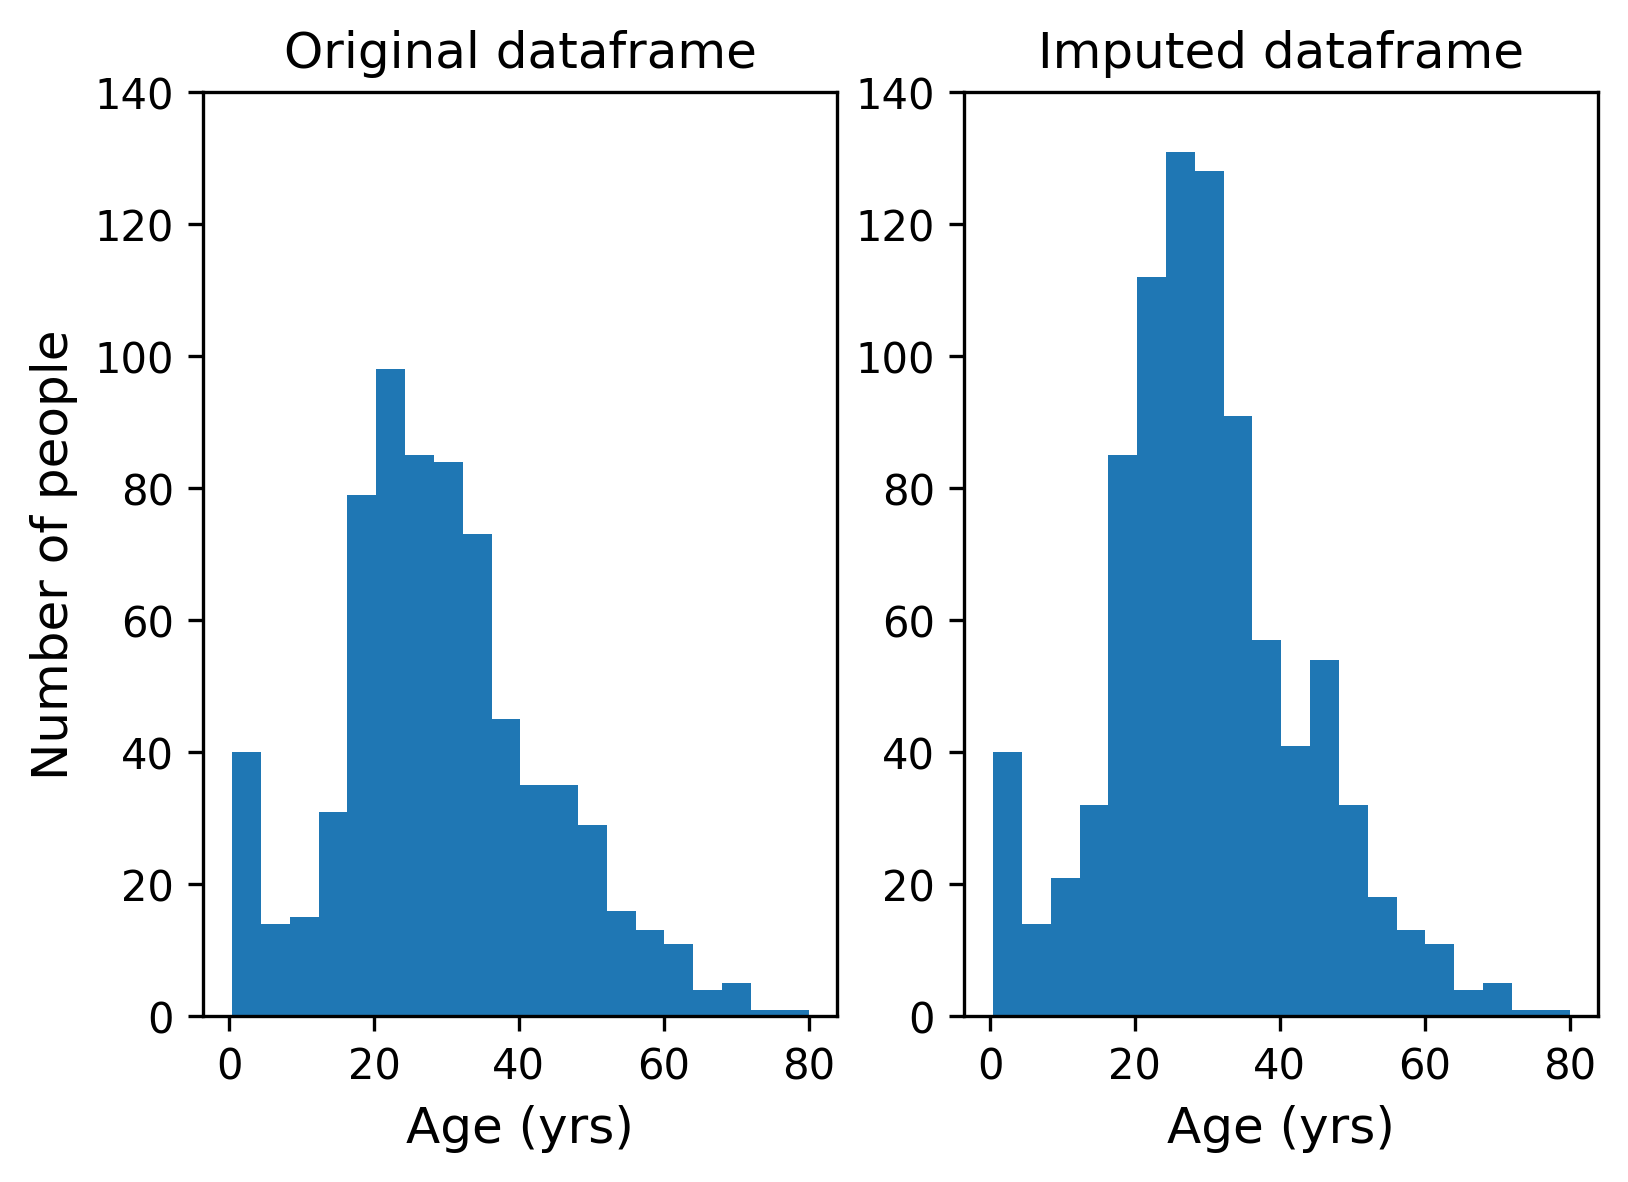

In [10]:
# Columns to drop in preparing the dataframes
drop_columns = ["Embarked", "Ticket", "Name", 'PassengerId']

new_train_df = prepare_dataframe(train_df, drop_columns)
new_test_df = prepare_dataframe(test_df, drop_columns)

#Plotting histograms of the feature variables
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (6,4))

# Create histograms
ax0.hist(train_df["Age"], bins=20);
ax1.hist(new_train_df["Age"], bins=20, );

# Set labels
ax0.set_xlabel('Age (yrs)', fontsize = 12)
ax0.set_ylabel('Number of people', fontsize = 12)
ax1.set_xlabel('Age (yrs)', fontsize = 12)
ax0.set_title('Original dataframe')
ax1.set_title('Imputed dataframe')
ax0.set_ylim(0,140)
ax1.set_ylim(0,140)

print(new_train_df["Age"].isna().sum())
print(train_df["Age"].isna().sum())

## Quick fitting of the data with a default Random forest classifier

In [11]:
# Setup the random seed
np.random.seed(42)

# Prepare dataframes
new_train_df = prepare_dataframe(train_df, drop_columns)
new_test_df = prepare_dataframe(test_df, drop_columns)

# First RandomForestClassifier 

# Split up into feature variables and target variables
x_train = new_train_df.drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]
# Instantiate the classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(x_train, y_train)

# Predictions of the training data
y_preds = clf.predict(x_train)

print(accuracy_score(y_preds, y_train))

0.9854096520763187


## Visualise the feature importance of the Random forest classifier

{'Sex': 0.10115369425319348, 'Age': 0.2145711055036223, 'SibSp': 0.03376834271653939, 'Parch': 0.02124709822686395, 'Fare': 0.19318520574199843, 'Familysize': 0.050156007330170546, 'Embarked_C': 0.011638889684741298, 'Embarked_Q': 0.008906454122481065, 'Embarked_S': 0.013621343274880899, 'Title_Master': 0.009747619527872828, 'Title_Miss': 0.04046918573191462, 'Title_Mr': 0.12899806102318012, 'Title_Mrs': 0.034107238909895955, 'Deck_A': 0.0026293661081413255, 'Deck_B': 0.00547367135362058, 'Deck_C': 0.006055685486443146, 'Deck_D': 0.005518572134757125, 'Deck_E': 0.007727198355332529, 'Deck_F': 0.001424786907102664, 'Deck_G': 0.0015835936166722808, 'Deck_U': 0.03178461423154395, 'Pclass_1': 0.02401362983205262, 'Pclass_2': 0.015564093307699652, 'Pclass_3': 0.0366545426192793}


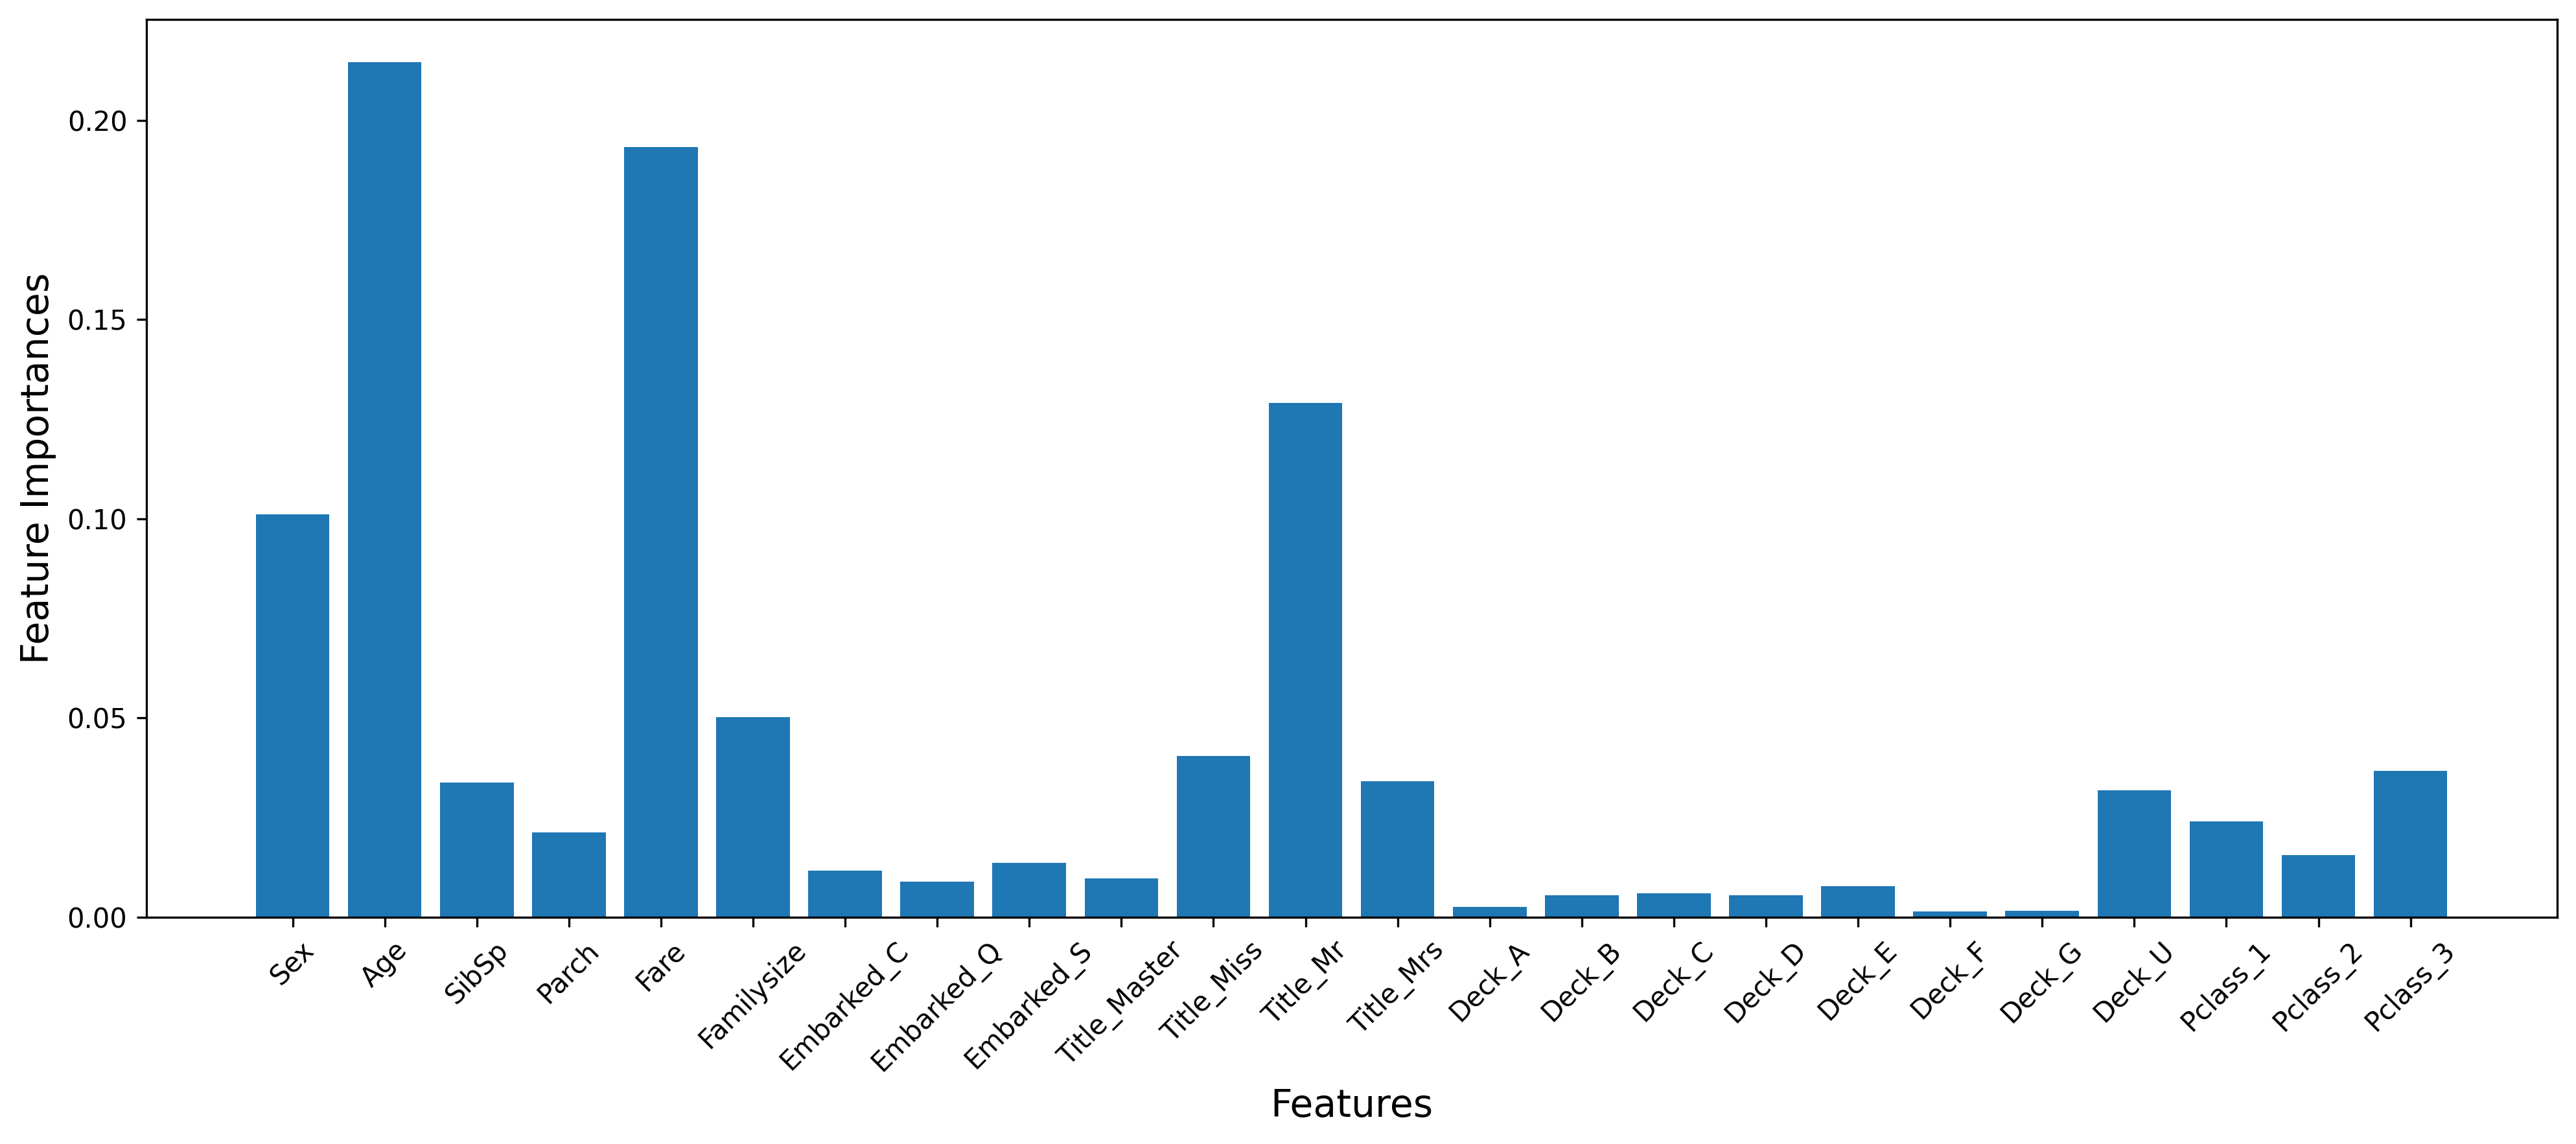

In [12]:
# Gives the importance of different features of the model
importance = clf.feature_importances_

# Shortened columns to appear on one plot
columns = x_train.columns

# The importance of the different feautures according to the model
importance_dictionary = {columns[i] : importance[i] for i in range(len(importance)) }
print(importance_dictionary)

keys = importance_dictionary.keys()
values = importance_dictionary.values()

# Plotting the feature importance
plt.figure(figsize=(16, 6))
plt.bar(keys, values)
plt.xlabel('Features', size=14)
plt.ylabel('Feature Importances', size=14)
plt.xticks(rotation=45)
plt.show()

## Exhaustive grid search of the optimal hyperparameters for a random forest classifier, using cross-validation to minimise overfitting

In [13]:
# Setup the random seed 
np.random.seed(42)

# # Random forest model discluding all the features below
drop_columns_decks = ["Embarked", "Ticket", "Name", 'PassengerId']

# Print which columns we are including 
print(set(train_df.columns)-set(drop_columns_decks))

# Grid of hyperparameters to sample from
grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [None, 10, 20, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_features': ['sqrt'],
    'bootstrap': [True, False]
}

# Creating dataframes discluding the titles
x_train_decks = prepare_dataframe(train_df, drop_columns_decks).drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]
x_test_decks = prepare_dataframe(test_df, drop_columns_decks)

# Instantiating the Random Forest Classifier
clf = RandomForestClassifier(n_jobs = 1)

# Setting up randomised search of hyperparameters (considers 10 combinations) with cross validation
'''
rs_clf_decks = RandomizedSearchCV(estimator = clf, param_distributions=grid,
                       n_iter = 10, # number of models to try
                       cv = 5, # Setting the test set as the validation set
                       verbose =2 # Prints out information as it is running
                       )
'''
'''
# Setting up exhaustive grid search of hyperparameters (considers 288 combinations) with cross validation
gs_clf_decks = GridSearchCV(estimator = clf, param_grid=grid,
                       cv = 5, # Setting the test set as the validation set
                       verbose =1 # Prints out information as it is running
                       )

# Fit the classifier
gs_clf_decks.fit(x_train_decks, y_train);
# Best parameters of the 10 iterations
best_params_decks = gs_clf_decks.best_params_
# Dataframe of the results of each hyperparameter combination
cv_results_decks = gs_clf_decks.cv_results_
'''

{'Sex', 'Fare', 'Parch', 'SibSp', 'Cabin', 'Pclass', 'Survived', 'Age'}


'\n# Setting up exhaustive grid search of hyperparameters (considers 288 combinations) with cross validation\ngs_clf_decks = GridSearchCV(estimator = clf, param_grid=grid,\n                       cv = 5, # Setting the test set as the validation set\n                       verbose =1 # Prints out information as it is running\n                       )\n\n# Fit the classifier\ngs_clf_decks.fit(x_train_decks, y_train);\n# Best parameters of the 10 iterations\nbest_params_decks = gs_clf_decks.best_params_\n# Dataframe of the results of each hyperparameter combination\ncv_results_decks = gs_clf_decks.cv_results_\n'

## Obtain best hyperparameters of the grid search and visualise the feature importances of the best RF classifier

In [14]:
'''
# Results of the cross validation
print(best_params_decks)
print(cv_results_decks["mean_test_score"].mean())

# Dataframe results of the 10 iterations
cv_results_decks_df = pd.DataFrame(cv_results_decks)
display(cv_results_decks_df)

importance = gs_clf_decks.best_estimator_.feature_importances_

# Custom columns to fit in the plot (previous labels too long)
columns = x_train_decks.columns

# Feature importances according to the classifier
importance_dictionary = {columns[i] : importance[i] for i in range(len(importance)) }
importance

keys = importance_dictionary.keys()
values = importance_dictionary.values()

# Plot the feature importance
plt.figure(figsize=(17, 6))
plt.bar(keys, values)
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.title('Feature importance')
plt.show()
'''

'\n# Results of the cross validation\nprint(best_params_decks)\nprint(cv_results_decks["mean_test_score"].mean())\n\n# Dataframe results of the 10 iterations\ncv_results_decks_df = pd.DataFrame(cv_results_decks)\ndisplay(cv_results_decks_df)\n\nimportance = gs_clf_decks.best_estimator_.feature_importances_\n\n# Custom columns to fit in the plot (previous labels too long)\ncolumns = x_train_decks.columns\n\n# Feature importances according to the classifier\nimportance_dictionary = {columns[i] : importance[i] for i in range(len(importance)) }\nimportance\n\nkeys = importance_dictionary.keys()\nvalues = importance_dictionary.values()\n\n# Plot the feature importance\nplt.figure(figsize=(17, 6))\nplt.bar(keys, values)\nplt.xlabel(\'Features\')\nplt.ylabel(\'Feature Importances\')\nplt.title(\'Feature importance\')\nplt.show()\n'

## Perform cross validation with only one hyperparameter combination to quickly see the improvements of any new feature engineering. 
### Can use the default hyperparameters or optimal ones


In [15]:
np.random.seed(42)
# Run cross validation on the best hyperparameters to test feature engineering 
drop_columns_decks = ["Embarked", "Ticket", "Name", 'PassengerId']

# Best hyperparameters according to grid search 
grid = {
    'bootstrap': [True], 'max_depth': [10], 'max_features': ['sqrt'],
                                      'min_samples_leaf': [4], 'min_samples_split': [2], 'n_estimators': [100]
}
# Hyperparameters used by default random forest classifier
default_grid = {
    'bootstrap': [True], 'max_depth': [None], 'max_features': ['sqrt'],
                                      'min_samples_leaf': [1], 'min_samples_split': [2], 'n_estimators': [100]
}

# X and y data if imputing the training and test set separately
x_train_decks = prepare_dataframe(train_df, drop_columns_decks).drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]

# X and y data if imputing the training and test set together
# x_train_decks = prepare_dataframe(combined_df, drop_columns_decks).drop(["Survived"], axis=1)[:891]
# y_train = new_train_df["Survived"]

clf = RandomForestClassifier(n_jobs = -1)

clf_decks = GridSearchCV(estimator = clf, param_grid=grid,
                       cv = 5, # Setting the test set as the validation set
                       verbose =1 # Prints out information as it is running
                       )

# Fit the classifier
clf_decks.fit(x_train_decks, y_train);
# Best parameters of the 10 iterations
best_params_decks = clf_decks.best_params_
# Dataframe of the results of each hyperparameter combination
cv_results_decks = clf_decks.cv_results_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


## Feature importance of the quick cross validation shown above

{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
0.8294017952419811


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.344151,0.026158,0.03916,0.000311,True,10,sqrt,4,2,100,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",0.832402,0.808989,0.837079,0.814607,0.853933,0.829402,0.016157,1


{'Sex': 0.20087417325243276, 'Age': 0.07437594593320047, 'SibSp': 0.03271971901364607, 'Parch': 0.01886932757701697, 'Fare': 0.09672866638684989, 'Familysize': 0.05119750858750302, 'Embarked_C': 0.011937710861842681, 'Embarked_Q': 0.005249457945152124, 'Embarked_S': 0.011755838483859532, 'Title_Master': 0.010034876164496769, 'Title_Miss': 0.058850439796625784, 'Title_Mr': 0.20540042660729543, 'Title_Mrs': 0.05083283373365464, 'Deck_A': 0.0017859047108854478, 'Deck_B': 0.0057568012232335096, 'Deck_C': 0.0055226878115198575, 'Deck_D': 0.006508213285411593, 'Deck_E': 0.008268030275799625, 'Deck_F': 0.0003147494296360604, 'Deck_G': 0.00014734881050485762, 'Deck_U': 0.03239972845700125, 'Pclass_1': 0.03245027079695815, 'Pclass_2': 0.01768347403693528, 'Pclass_3': 0.060335866818538246}


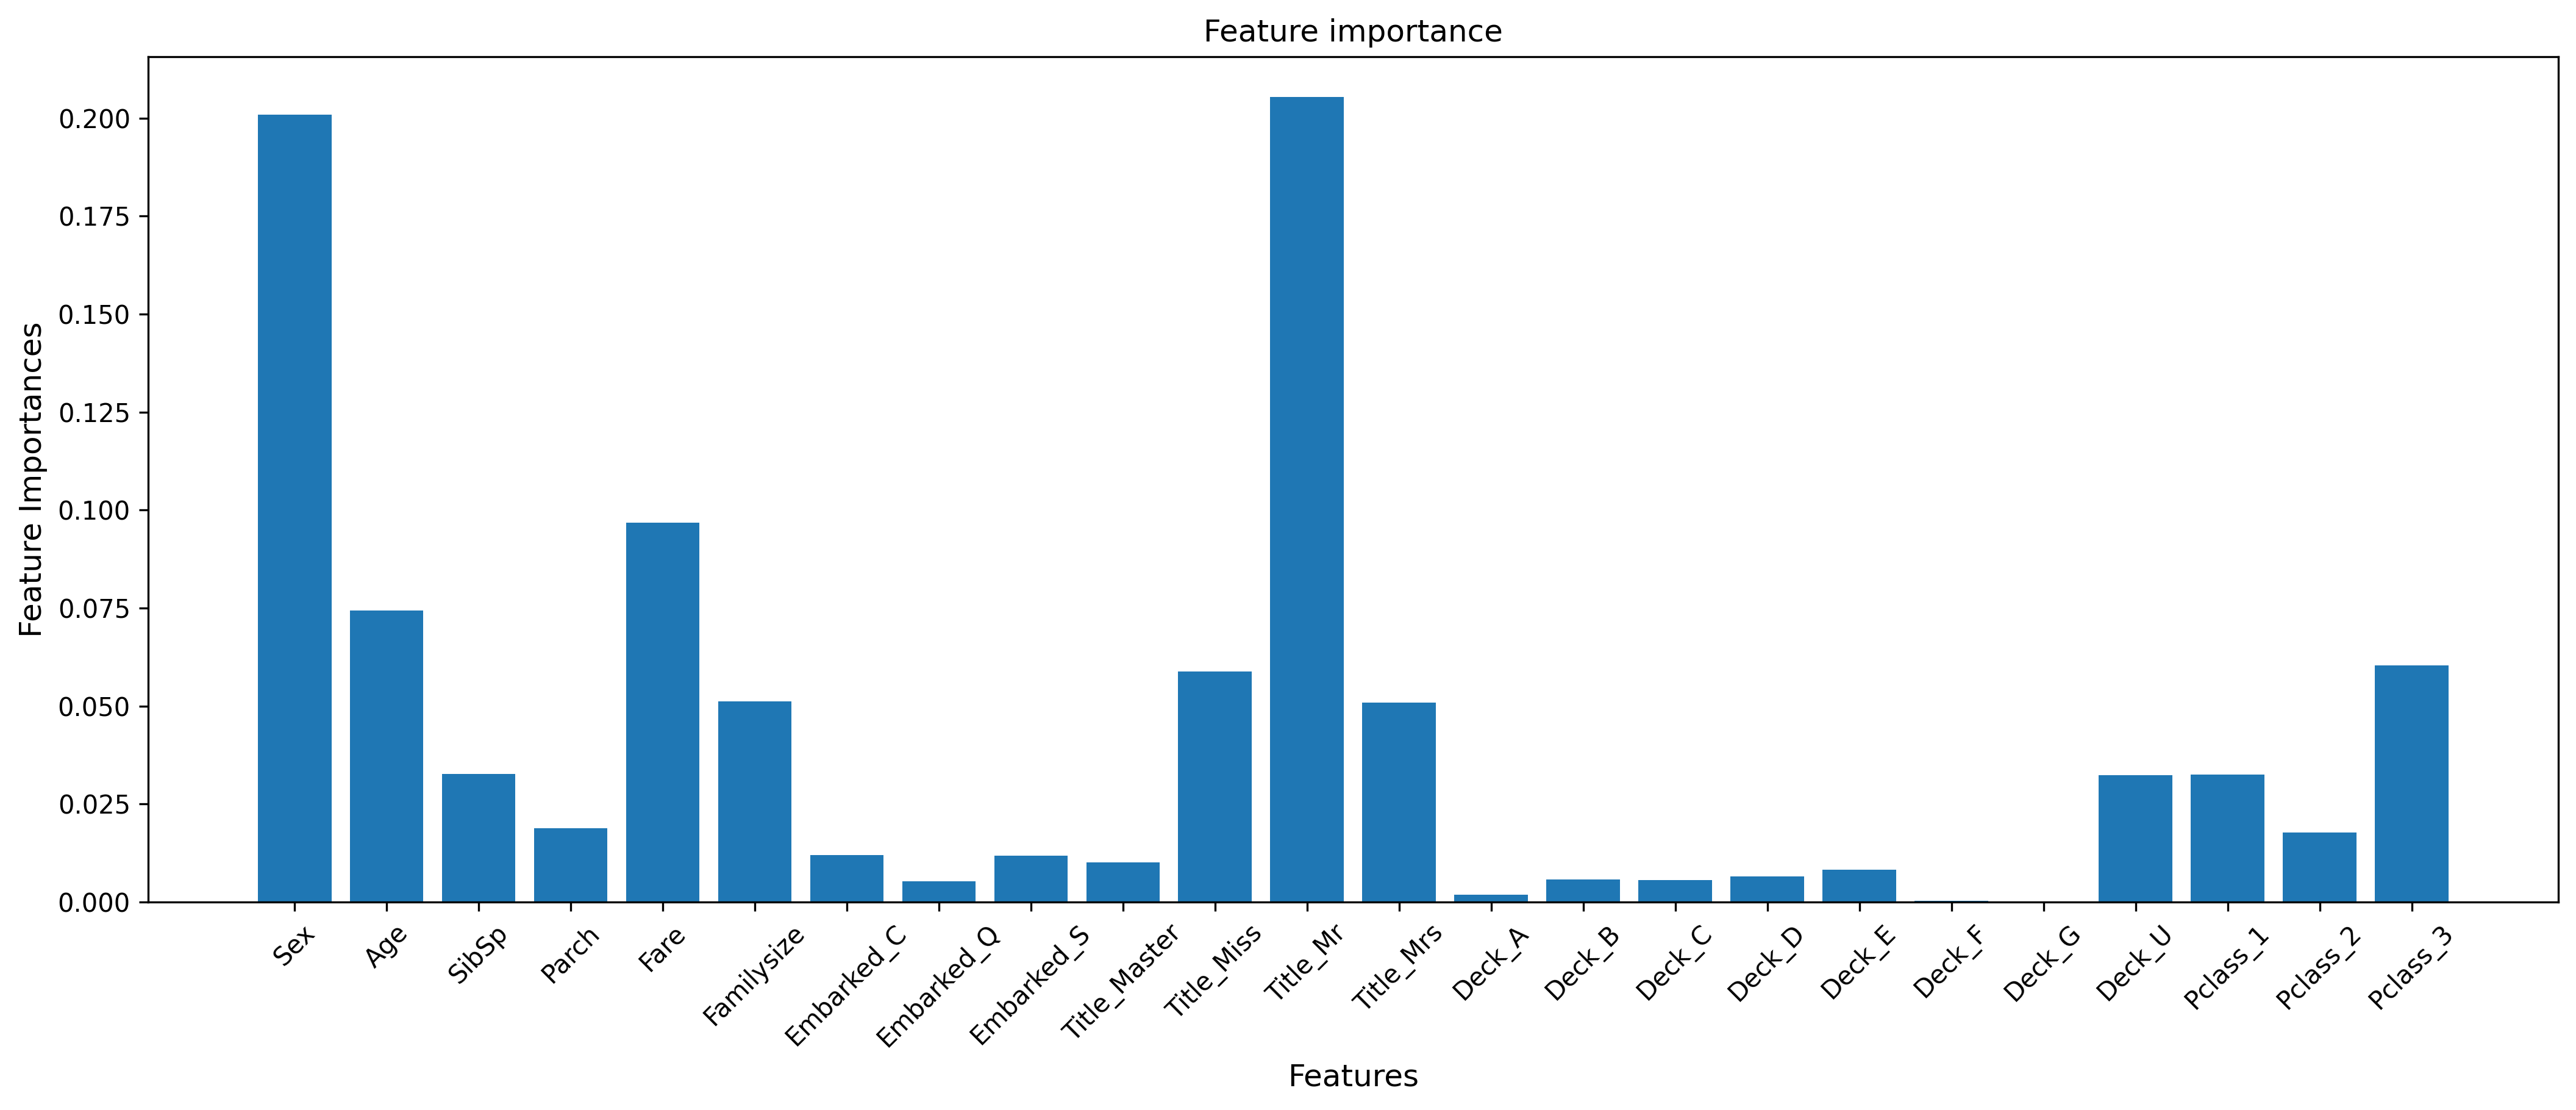

In [16]:
# Results of the cross validation
print(best_params_decks)
print(cv_results_decks["mean_test_score"].mean())

# Dataframe results of the 10 iterations
cv_results_decks_df = pd.DataFrame(cv_results_decks)
display(cv_results_decks_df)

importance = clf_decks.best_estimator_.feature_importances_

# Custom columns to fit in the plot (previous labels too long)
columns = x_train_decks.columns

# Feature importances according to the classifier
importance_dictionary = {columns[i] : importance[i] for i in range(len(importance)) }
print(importance_dictionary)

keys = importance_dictionary.keys()
values = importance_dictionary.values()

# Plot the feature importance
plt.figure(figsize=(17, 6))
plt.bar(keys, values)
plt.xlabel('Features', size=12)
plt.ylabel('Feature Importances', size=12)
plt.title('Feature importance', size=12)
plt.xticks(rotation=45)
plt.show()

## Exhaustive grid search of the optimal hyperparameters for a Logistic Regression classifier, using cross-validation to minimise overfitting

In [17]:
# Setup random seed 
np.random.seed(42)

# Discluding these features
drop_columns_decks = ["Embarked", "Ticket", "Name", "PassengerId"]

# Logistic regression hyperparameters to sample from 
log_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.5, 1, 2, 3],
    'solver': ['liblinear'],
    'class_weight': [None, 'balanced'],
    'max_iter': [2000, 4000],
    'tol': [0.0001, 0.001, 0.01],
    'multi_class': ['ovr']
}

# Creating dataframes
x_train_decks = prepare_dataframe(train_df, drop_columns_decks).drop(["Survived"], axis=1)
y_train = prepare_dataframe(train_df, drop_columns_decks)['Survived']
x_test_decks = prepare_dataframe(test_df, drop_columns_decks)

# Instantiating the Logistic regression classifier
log_clf = LogisticRegression()

# Setting up randomised search of hyperparameters (considers 10 combinations) with cross validation
gs_log_clf_decks = GridSearchCV(estimator = log_clf, param_grid=log_grid,
                       cv = 5, # Setting the test set as the validation set
                       verbose =1 # Prints out information as it is running
                       )
'''
# Fit the classifier
gs_log_clf_decks.fit(x_train_decks, y_train);
# Best parameters of the 10 iterations
log_best_params_decks = gs_log_clf_decks.best_params_
# Dataframe of the results of each hyperparameter combination
log_cv_results_decks = gs_log_clf_decks.cv_results_
'''

'\n# Fit the classifier\ngs_log_clf_decks.fit(x_train_decks, y_train);\n# Best parameters of the 10 iterations\nlog_best_params_decks = gs_log_clf_decks.best_params_\n# Dataframe of the results of each hyperparameter combination\nlog_cv_results_decks = gs_log_clf_decks.cv_results_\n'

## Obtain best hyperparameters of the grid search and visualise the feature importances of the best LR classifier

In [18]:
'''
# Results of the cross validation 
print(log_best_params_decks)
print(log_cv_results_decks["mean_test_score"].mean())

# Dataframe results of the 10 iterations
log_cv_results_decks_df = pd.DataFrame(log_cv_results_decks)
display(log_cv_results_decks_df)
'''

'\n# Results of the cross validation \nprint(log_best_params_decks)\nprint(log_cv_results_decks["mean_test_score"].mean())\n\n# Dataframe results of the 10 iterations\nlog_cv_results_decks_df = pd.DataFrame(log_cv_results_decks)\ndisplay(log_cv_results_decks_df)\n'

## Made my own cross-validation function to be able to produce ROC curves for any of the k-fold classifiers 

In [19]:
# Setup random seed
np.random.seed(42)

# Function to divide a dataframe into validation and training sets with cross validation (k-folds). Returns the desired fold  
def cross_val_index(k_folds, dataframe, fold_number):
    dataframe.sample(frac=1)
    x_dataframe = dataframe.drop(["Survived"], axis=1)
    y_dataframe = dataframe["Survived"]
    
    index = round(len(x_dataframe)/k_folds)
    start_index, end_index = [], []
    for i in range(k_folds):
                start_index.append(i * index)
                end_index.append((i + 1) * index if i < k_folds - 1 else len(x_dataframe))
    # print(start_index[fold_number-1], end_index[fold_number-1])
    X_train = pd.concat([x_dataframe[:start_index[fold_number-1]], x_dataframe[end_index[fold_number-1]:]])
    y_train = pd.concat([y_dataframe[:start_index[fold_number-1]], y_dataframe[end_index[fold_number-1]:]])
    X_valid = x_dataframe[start_index[fold_number-1]:end_index[fold_number-1]]
    y_valid = y_dataframe[start_index[fold_number-1]:end_index[fold_number-1]]
    
    return X_train, y_train, X_valid, y_valid


# Columns to drop
drop_columns = ["Embarked", "Ticket", "Name", "PassengerId"]

# Setting up validation dataframes
new_train_df = prepare_dataframe(train_df, drop_columns)

# Calling the function to get the folded dataframes
cross_val_dataframes = cross_val_index(5, new_train_df, 5)

# Calculating the probabilities of prediction with the best RandomForestClassifier
best_clf = RandomForestClassifier( **{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt',
                                      'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100})
best_clf.fit(cross_val_dataframes[0], cross_val_dataframes[1])
best_y_valid_preds = best_clf.predict(cross_val_dataframes[2])
best_y_valids_proba = best_clf.predict_proba(cross_val_dataframes[2])
best_y_valids_proba_pos = best_y_valids_proba[:, 1]
# print(accuracy_score(best_y_valid_preds, cross_val_dataframes[3]))

# Calculating the probabilities of prediction with the worst RandomForestClassifier
worst_clf = RandomForestClassifier( **{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False})
worst_clf.fit(cross_val_dataframes[0], cross_val_dataframes[1])
worst_y_valid_preds = worst_clf.predict(cross_val_dataframes[2])
worst_y_valids_proba = worst_clf.predict_proba(cross_val_dataframes[2])
worst_y_valids_proba_pos = worst_y_valids_proba[:, 1]
# print(accuracy_score(worst_y_valid_preds, cross_val_dataframes[3]))

# print classification reports for the best and worst validation predictions
print("Best model report: \n", classification_report(best_y_valid_preds, cross_val_dataframes[3]))
print("Worst model report: \n", classification_report(worst_y_valid_preds, cross_val_dataframes[3]))

Best model report: 
               precision    recall  f1-score   support

           0       0.90      0.88      0.89       117
           1       0.78      0.81      0.79        62

    accuracy                           0.85       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.86      0.85      0.86       179

Worst model report: 
               precision    recall  f1-score   support

           0       0.84      0.87      0.85       112
           1       0.77      0.73      0.75        67

    accuracy                           0.82       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



In [20]:
# Calculating the rates and thresholds for the two classifiers
best_fpr, best_tpr, best_thresholds = roc_curve(cross_val_dataframes[3].values, best_y_valids_proba_pos)
worst_fpr, worst_tpr, worst_thresholds = roc_curve(cross_val_dataframes[3].values, worst_y_valids_proba_pos)

# Area under the curve for the best and worst predictor
print(roc_auc_score(cross_val_dataframes[3].values, best_y_valids_proba_pos))
print(roc_auc_score(cross_val_dataframes[3].values, worst_y_valids_proba_pos))

0.9203125000000001
0.8805027173913044


## ROC curve for the best and worst RF classifiers. 
### It shows the last fold of the five, would have made an average but roc_curve produces a different number of points for each fold

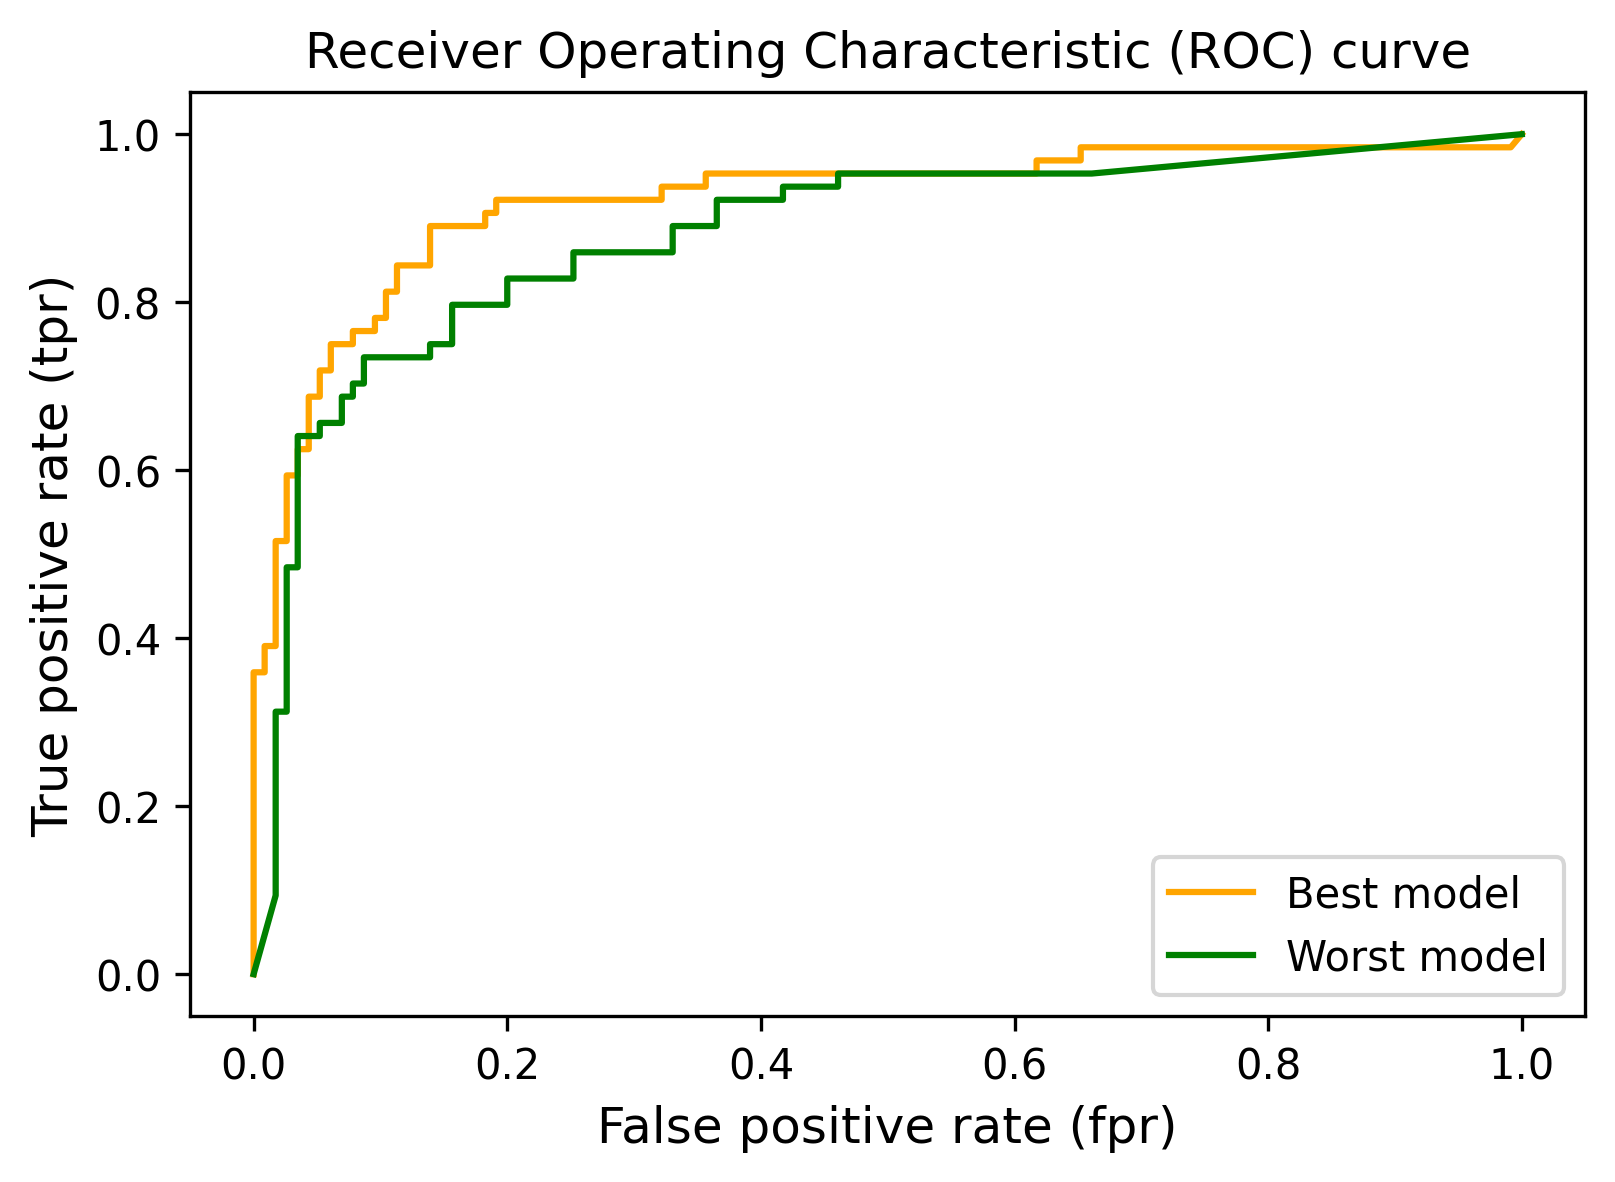

In [21]:
# Plotting the ROC curves for the best and worst classifiers 
plt.figure(figsize=(6,4))
plt.plot(best_fpr, best_tpr, color='orange', label='Best model')
plt.plot(worst_fpr, worst_tpr, color='green', label='Worst model')
plt.xlabel('False positive rate (fpr)', size=12)
plt.ylabel('True positive rate (tpr)', size=12)
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend()
plt.show()

## Creating a submission file based on whichever columns, `prepare_dataframe` function, classifier or hyperparameters you would like to consider
### This version specifically includes almost all the features, imputing the age column with KNN, using a Random Forest classifier and the optimal hyperparameters using a grid search

In [22]:
# Dropping only unnecessary columns
drop_columns = ["Embarked", "Ticket", "Name", "PassengerId"]
'''
# Prepare dataframes
new_train_df = prepare_dataframe(train_df, drop_columns)
x_train = new_train_df.drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]
x_test = prepare_dataframe(test_df, drop_columns)
'''

# Preparing dataframes with combined imputing
new_train_df = prepare_dataframe(combined_df, drop_columns)
x_train = new_train_df.drop(["Survived"], axis=1)[:891]
y_train = new_train_df["Survived"][:891]
x_test = new_train_df.drop(["Survived"], axis=1)[891:]

# Instantiate Random Forest Classifier with best hyperparameters
best_clf = RandomForestClassifier( **{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt',
                                      'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100})

# Fit the classifier and make predictions
best_clf.fit(x_train, y_train)
best_y_preds = best_clf.predict(x_test).astype(int)

# Create a csv file with the predictions
output = gender_submission.copy(deep=True)
output['Survived']=best_y_preds
print(output)
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]
Your submission was successfully saved!


## Creating a submission file based on whichever columns, `prepare_dataframe` function, classifier or hyperparameters you would like to consider
### This version specifically includes almost all the features, imputing the age column with KNN, using a Logistic Regression Model and its respective optimal hyperparameters using a grid search

In [23]:
# Dropping only unnecessary columns
drop_columns = ["Embarked", "Ticket", "Name", "PassengerId"]
'''
# Prepare dataframes
new_train_df = prepare_dataframe(train_df, drop_columns)
x_train = new_train_df.drop(["Survived"], axis=1)
y_train = new_train_df["Survived"]
x_test = prepare_dataframe(test_df, drop_columns)
'''

# Preparing dataframes with combined imputing
new_train_df = prepare_dataframe(combined_df, drop_columns)
x_train = new_train_df.drop(["Survived"], axis=1)[:891]
y_train = new_train_df["Survived"][:891]
x_test = new_train_df.drop(["Survived"], axis=1)[891:]

# Instantiate Random Forest Classifier with best hyperparameters
best_clf = LogisticRegression( **{'C': 2, 'class_weight': None, 'max_iter': 2000, 'multi_class': 'ovr',
                                 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.01})

# Fit the classifier and make predictions
best_clf.fit(x_train, y_train)
best_y_preds = best_clf.predict(x_test).astype(int)

# Create a csv file with the predictions
output = gender_submission.copy(deep=True)
output['Survived']=best_y_preds
# print(output)
# output.to_csv('submission.csv', index=False)
# print("Your submission was successfully saved!")
print("Your submission NOT successfully saved!!!")

Your submission NOT successfully saved!!!
